<a href="https://colab.research.google.com/github/khchoi-physik/pbh_simulations/blob/main/nearest_neighbour_analysis_2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.special import erf
from sklearn.cluster import DBSCAN
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib import cm

import glob
import os
import gc

In [ ]:
def grf_2d(mean, std_dev, pixel, amplitude, k_power):
    # Generate white noise in-place
    white_noise = np.random.normal(mean, std_dev, (pixel, pixel))

    # 2D Fast Fourier transform of the white noise
    fft_white_noise = np.fft.fft2(white_noise)
    del white_noise
    gc.collect()

    # Generating FFT momentum
    kx = np.fft.fftfreq(pixel) * pixel
    ky = np.fft.fftfreq(pixel) * pixel

    # Generating FFT momentum 2D array
    kx_grid, ky_grid = np.meshgrid(kx, ky)
    del kx, ky
    gc.collect()

    # Norm of k
    k_norm = np.sqrt(kx_grid**2 + ky_grid**2)
    k_norm[0, 0] = np.inf  # Regularize divergence at k=0
    del kx_grid, ky_grid
    gc.collect()

    # Power Spectrum P_k
    power_spectrum = amplitude * (((2 * np.pi / pixel) * k_norm) ** (-k_power))
    del k_norm  # Free memory
    gc.collect()

    # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
    fourier_amplitudes_sqrt = np.sqrt(power_spectrum, out=power_spectrum) * fft_white_noise
    del power_spectrum, fft_white_noise  # Free memory
    gc.collect()

    # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
    gaussian_random_field = np.fft.ifft2(fourier_amplitudes_sqrt).real
    del fourier_amplitudes_sqrt  # Free memory
    gc.collect()

    return gaussian_random_field




def gaussian_to_exp(x, lam):
    mu = np.mean(x)
    sigma = np.std(x)
    xu = 0.5 * (1 + erf((x - mu) / (np.sqrt(2) * sigma)))
    return -1/lam  * np.log(1 - xu)


In [ ]:
exprf = gaussian_to_exp( grf_2d(mean= 0, std_dev = 1, pixel= 2**13, amplitude = 1, k_power=2), 1)

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# k_power =1

# folder_path = '/content/gdrive/MyDrive/2023 RFSimulations/simulated_field/'
# main_path = folder_path + f'k_{k_power}'

In [ ]:
# os.chdir(main_path)

# exprf_list = glob.glob('exprf*.npy')
# print(exprf_list)
# exprf = np.load(exprf_list[0])
print(exprf.shape)

(8192, 8192)


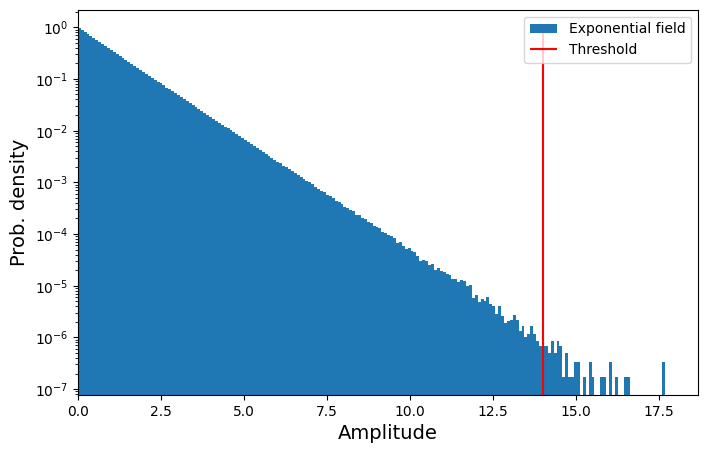

In [ ]:
threshold = 14

plt.figure( figsize = (8,5))
plt.hist(exprf.flatten(), bins=201, density=True, label='Exponential field');
plt.yscale('log')
plt.xlim(0,exprf.max()+1)
plt.xlabel('Amplitude', fontsize=14)
plt.ylabel('Prob. density', fontsize=14)
plt.vlines(threshold,0,1, color='r', label='Threshold')
plt.legend()
plt.savefig('Prob_dens.pdf', bbox_inches='tight', dpi=300)
plt.show()

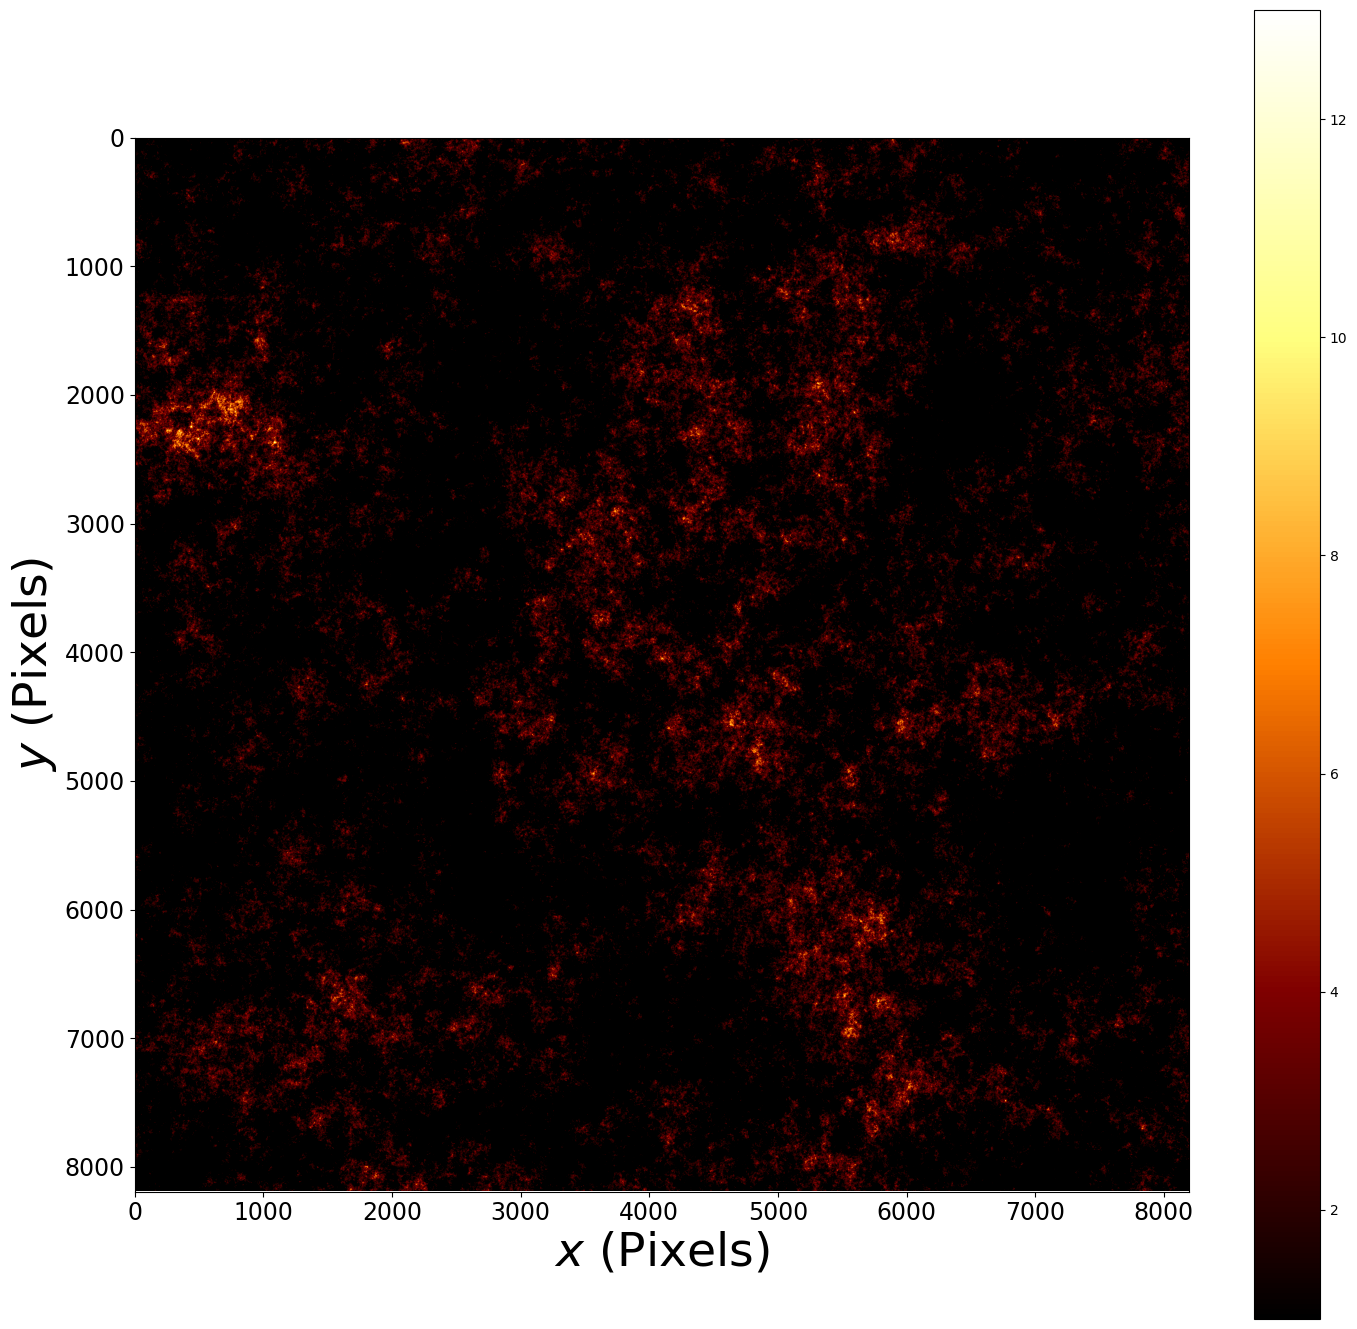

In [ ]:
psize = 17
plt.figure( figsize = (psize,psize))
plt.imshow(exprf, cmap='afmhot')
plt.xlabel(f'$x$ (Pixels)',fontsize=psize*2)
plt.ylabel(f'$y$ (Pixels)',fontsize=psize*2)
plt.xticks(fontsize=psize)
plt.yticks(fontsize=psize)
plt.colorbar()
plt.clim(1,threshold)
plt.savefig('Field.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# threshold = 11  # 2048
threshold = threshold # 8192
mask = exprf > threshold

In [ ]:
pos = np.argwhere(mask)
print(pos.shape)

(49, 2)


In [ ]:
eps = 500
min_samples = 2

clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(pos)

In [ ]:
labels = clustering.labels_
print(labels)

[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  1  1 -1  2  2  2  2  2  2  2  2 -1 -1  3  3 -1
 -1]


In [ ]:
num_clt = len(set(labels))
cmap = cm.get_cmap('rainbow', num_clt)

print(num_clt)

5


<ipython-input-63-33e86091dd2b>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow', num_clt)


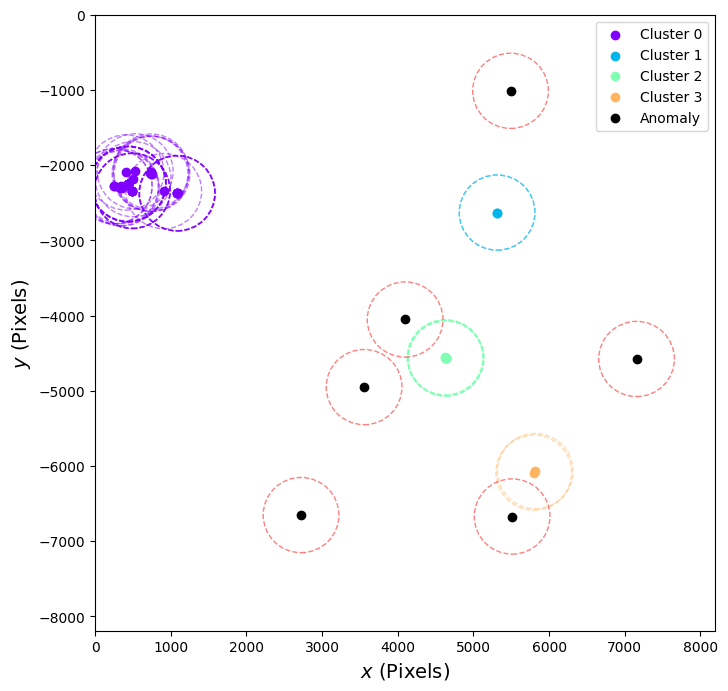

In [ ]:
plt.figure( figsize = (8,8))

for ii in set(labels):
    clt_idx = np.where(labels == ii)
    clt_pos = pos[clt_idx]
    color = cmap(ii % num_clt)

    if ii == -1:
        plt.scatter( clt_pos[:,1], -clt_pos[:,0] , c='k', label='Anomaly')
    else:
        plt.scatter( clt_pos[:,1], -clt_pos[:,0] , color = color, label=f'Cluster {ii}')

    for p in clt_pos:
        circle = plt.Circle((p[1], -p[0]), eps, color = color, fill=False, linestyle='--', alpha=0.5)  # You can adjust the circle properties here
        plt.gca().add_artist(circle)


plt.xlabel(f'$x$ (Pixels)', fontsize=14)
plt.ylabel(f'$y$ (Pixels) ', fontsize=14)
plt.xlim(0,exprf.shape[0])
plt.ylim(-exprf.shape[1],0)
plt.legend()
plt.savefig('Cluster.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# Initialize empty dictionary
clt_pos_dict = {}

# Iterate over all clustes
for ii in set(labels):

    # Find the index of the cluster
    clt_idx = np.where(labels == ii)
    # Find the coordinates of the cluster using the index
    clt_pos = pos[clt_idx]
    # Append the coordinates into the dictionary
    clt_pos_dict[ii] = clt_pos


In [ ]:
l = 1 ## box size = 2L+1

# Generate offsets for the 3x3 box
offsets = np.array( [(i,j) for i in range(-l,l+1) for j in range(-l,l+1)])

# Initialize empty dictionary to store the all coordinates of the box
coordinates = {}

# Iterate over each cluster in labels, exlcuding `-1`
for ii in set(labels) - {-1}:

    # Initialize empty list for collecting coordinates in cluster `ii`
    coordinates[ii] = []

    # Iterate over the coordinates of each box center
    for coor_center in clt_pos_dict[ii]:

        # Append the coordinates for the entire box (arrays)
        coordinates[ii].append(coor_center + offsets)

    # Concatenate lists of arrays into a single array
    coordinates[ii] = np.concatenate(coordinates[ii])

    # Remove duplications
    coordinates[ii] = np.unique(coordinates[ii], axis=0)

In [ ]:
# Intitialize dictionary for recording the amplitude and the total mass
amplitude_list, mass_list = {}, {}

# Iterate over clusters without "-1"
for ii in set(labels) - {-1}:

    # Collect the amplitudes in the cluster
    amplitude_list[ii] = exprf[ coordinates[ii][:,0] , coordinates[ii][:,1] ]

    # Sum to get total mass
    mass_list[ii] = np.sum(amplitude_list[ii])


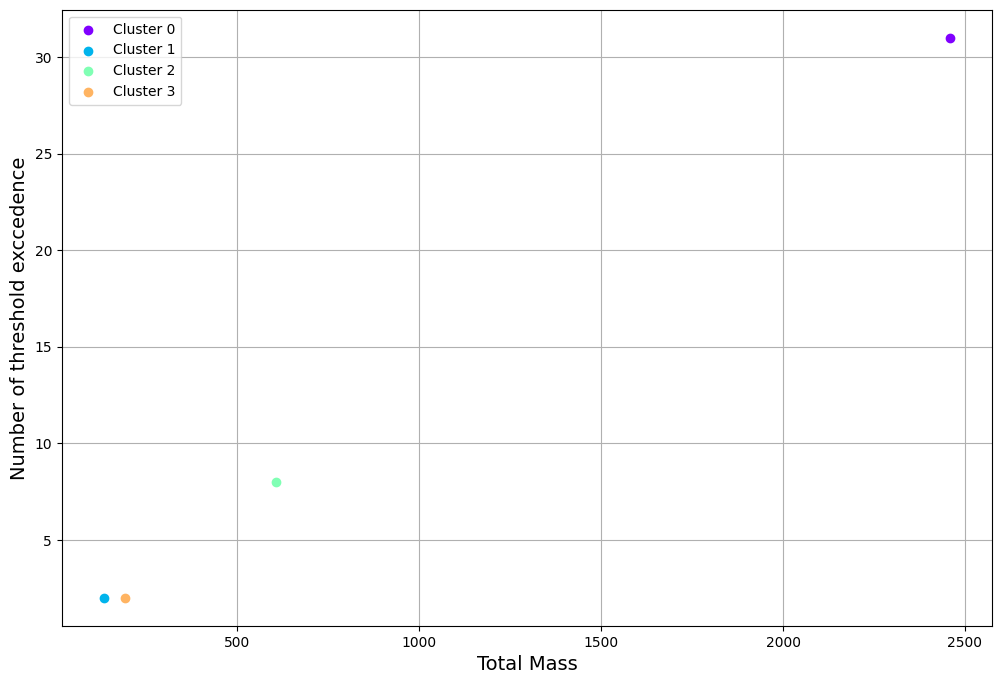

In [ ]:
plt.figure( figsize = (12,8))

for ii in set(labels) - {-1}:
    color = cmap(ii % num_clt)
    plt.scatter( mass_list[ii], clt_pos_dict[ii].shape[0], label=f'Cluster {ii}',  color = color)

plt.legend()
plt.xlabel('Total Mass', fontsize=14)
plt.ylabel('Number of threshold exccedence', fontsize=14)
plt.grid()
plt.savefig('Mass_vs_Thres_ex.pdf', bbox_inches='tight', dpi=300)
plt.show()

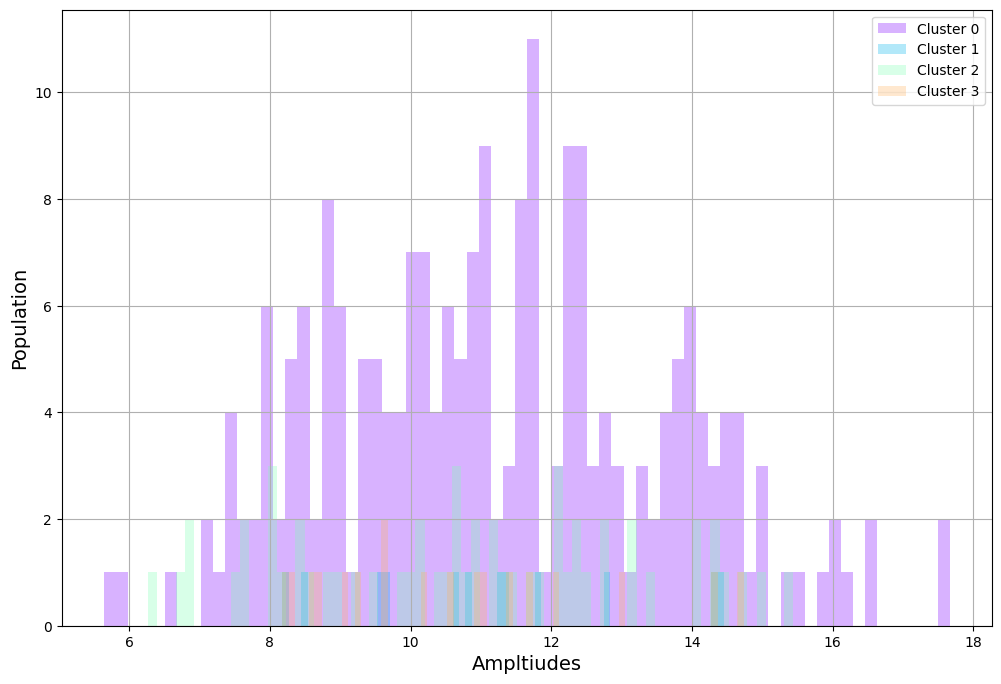

In [ ]:
plt.figure( figsize = (12,8))
for ii in set(labels) - {-1}:

    color = cmap(ii % num_clt)
    plt.hist(amplitude_list[ii], bins=70, label=f'Cluster {ii}', color = color, alpha=0.3)

plt.legend()
plt.xlabel('Ampltiudes', fontsize=14)
plt.ylabel('Population', fontsize=14)
plt.grid()
plt.savefig('Amp_hist.pdf', bbox_inches='tight', dpi=300)
plt.show()

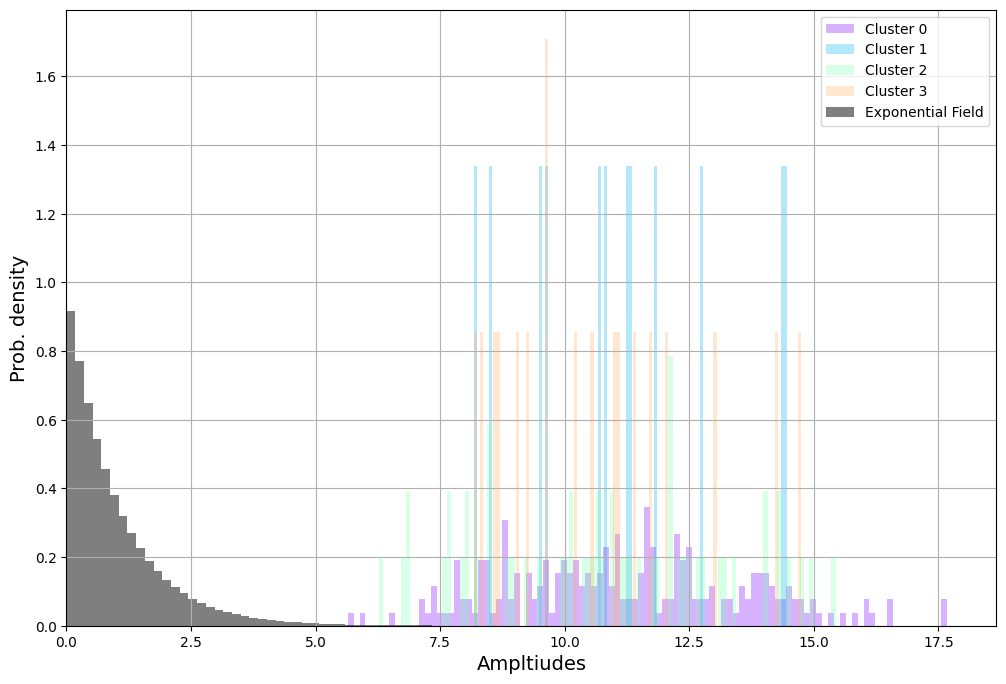

In [ ]:
plt.figure( figsize = (12,8))
for ii in set(labels) - {-1}:
    color = cmap(ii % num_clt)
    plt.hist(amplitude_list[ii], bins=101,  label=f'Cluster {ii}', color = color, density=True,alpha =0.3)

plt.hist(exprf.flatten(), bins=101,  label='Exponential Field', color = 'k', density=True, alpha=0.5)
plt.legend()
plt.xlabel('Ampltiudes', fontsize=14)
plt.ylabel('Prob. density', fontsize=14)
plt.xlim(0,exprf.max()+1)
plt.grid()
plt.savefig('Amp_hist_with_exprf.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
print(mass_list)

{0: 2458.0825267902374, 1: 133.43873354105602, 2: 605.6851797219076, 3: 191.34775526670174}


In [ ]:
print(coordinates[0][:,0], coordinates[0][:,0].min(), coordinates[0][:,0].max())

[2082 2082 2082 2083 2083 2083 2084 2084 2084 2085 2085 2085 2086 2086
 2086 2087 2087 2087 2097 2097 2097 2098 2098 2098 2099 2099 2099 2110
 2110 2110 2111 2111 2111 2112 2112 2112 2112 2112 2112 2113 2113 2113
 2114 2114 2114 2116 2116 2116 2117 2117 2117 2118 2118 2118 2186 2186
 2186 2187 2187 2187 2188 2188 2188 2248 2248 2248 2248 2249 2249 2249
 2249 2249 2249 2249 2250 2250 2250 2250 2250 2250 2250 2251 2251 2251
 2251 2251 2251 2252 2252 2252 2252 2252 2252 2253 2253 2253 2253 2253
 2254 2254 2254 2257 2257 2257 2258 2258 2258 2259 2259 2259 2279 2279
 2279 2279 2279 2279 2279 2280 2280 2280 2280 2280 2280 2280 2281 2281
 2281 2281 2281 2281 2281 2305 2305 2305 2306 2306 2306 2307 2307 2307
 2309 2309 2309 2310 2310 2310 2311 2311 2311 2339 2339 2339 2339 2340
 2340 2340 2340 2341 2341 2341 2341 2342 2342 2342 2343 2343 2343 2344
 2344 2344 2344 2345 2345 2345 2345 2345 2345 2345 2346 2346 2346 2346
 2346 2346 2346 2347 2347 2347 2371 2371 2371 2372 2372 2372 2373 2373
 2373 

Cluster 0


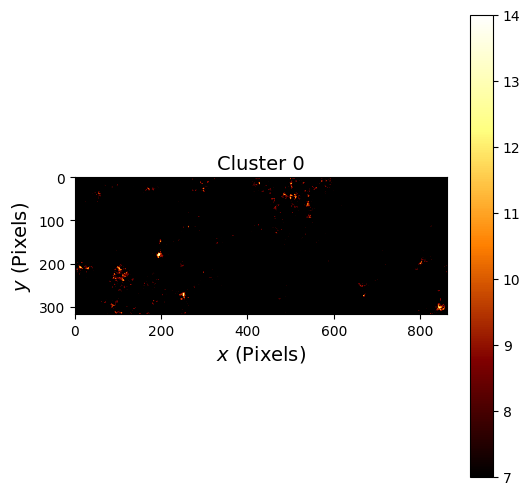

Cluster 1


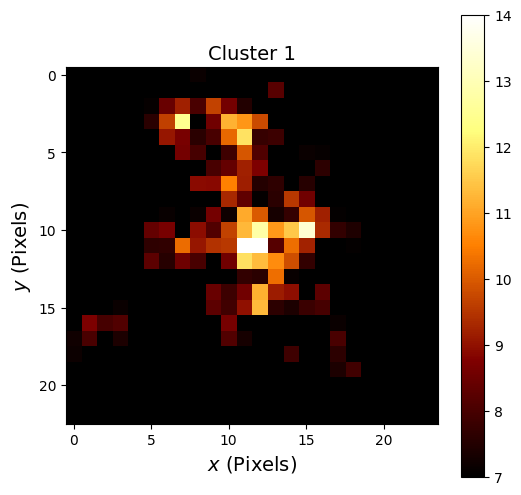

Cluster 2


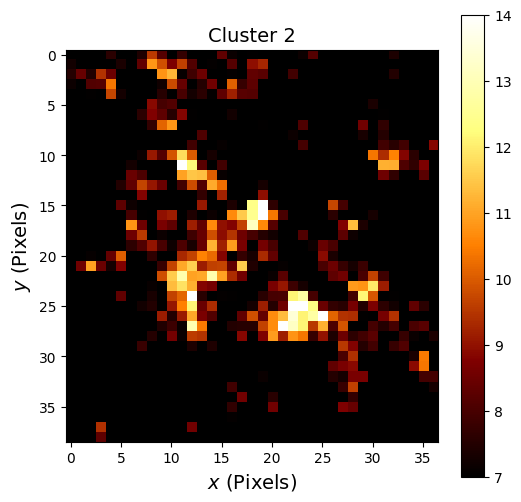

Cluster 3


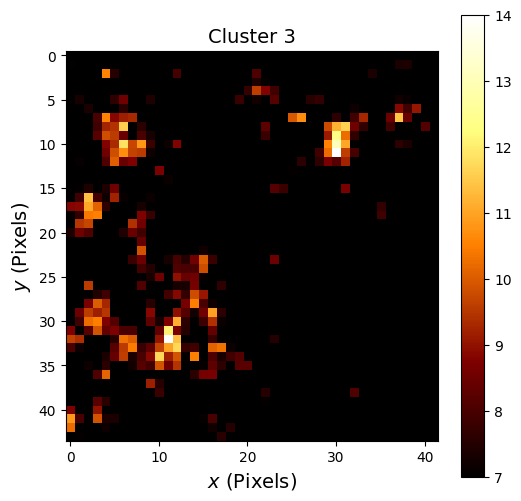

In [ ]:
for ii in set(labels) - {-1}:

    print(f'Cluster {ii}')

    l0 = 10

    xmin = coordinates[ii][:,0].min() - l0
    xmax = coordinates[ii][:,0].max() + l0 +1
    ymin = coordinates[ii][:,1].min() - l0
    ymax = coordinates[ii][:,1].max() + l0 +1

    subexprf = exprf[xmin:xmax , ymin:ymax]

    plt.figure(figsize = (6,6))

    plt.imshow(subexprf, cmap='afmhot')
    plt.title(f'Cluster {ii}', fontsize=14)
    plt.xlabel(f'$x$ (Pixels)',fontsize=14)
    plt.ylabel(f'$y$ (Pixels)',fontsize=14)
    plt.colorbar()
    plt.clim(threshold/2,threshold)
    plt.savefig(f'SmallCluster_{ii}.pdf', bbox_inches='tight', dpi=300)
    #plt.savefig('Field.pdf', bbox_inches='tight', dpi=300)
    plt.show()